In [7]:
import ee
import geemap



# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-anshulsg13')

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [8]:
!pip install numpy pandas geopandas rasterio Pillow matplotlib pyyaml shapely

.tif File Analysis


In [ ]:
import rasterio
from pathlib import Path

def print_band_names(input_tif):
    """
    Opens a GeoTIFF and prints the description (name) of each band.
    If no descriptions are present, it will simply number the bands.
    """
    input_tif = Path(input_tif)
    with rasterio.open(input_tif) as src:
        descriptions = src.descriptions  # a tuple of strings, one per band
        if any(descriptions):
            for idx, desc in enumerate(descriptions, start=1):
                print(f"Band {idx}: {desc}")
        else:
            for idx in range(1, src.count + 1):
                print(f"Band {idx}")

if __name__ == "__main__":
    tif_path = "honors_thesis/data/raw/location_3/sentinel2/july2022/location_3_2022_ndvi_comp.tif"
    print_band_names(tif_path)


Band 1: B2
Band 2: B3
Band 3: B4
Band 4: B8
Band 5: NDVI
Band 6: MSK_CLDPRB
Band 7: VALID
Band 8: missing


In [ ]:
import rasterio
import numpy as np
import csv
from pathlib import Path
from rasterio.errors import RasterioIOError

def analyze_tif_bands(input_tif, output_csv=None, percentiles=(5, 50, 95)):
    """
    Reads all bands from a GeoTIFF and computes basic statistics per band.

    Parameters:
      - input_tif (str or Path): Path to the .tif file.
      - output_csv (str or Path, optional): If provided, writes stats to this CSV.
      - percentiles (tuple of int): Which percentiles to compute.

    Returns:
      - stats (dict): Nested dict of stats per band (1-indexed).
    """
    input_tif = Path(input_tif)
    stats = {}

    try:
        with rasterio.open(input_tif) as src:
            meta = src.meta
            band_count = src.count
            print(f"File: {input_tif.name}")
            print(f"  CRS: {meta['crs']}")
            print(f"  Dimensions: {meta['width']} x {meta['height']} px")
            print(f"  Bands: {band_count}")
            print(f"  Dtype: {meta['dtype']}\n")

            for band_idx in range(1, band_count + 1):
                data = src.read(band_idx).astype('float32')
                # Mask out nodata if defined
                if src.nodata is not None:
                    mask = data == src.nodata
                    data = np.ma.array(data, mask=mask)

                band_stats = {
                    'count': int(data.size - data.mask.sum()) if np.ma.is_masked(data) else int(data.size),
                    'min': float(data.min()),
                    'max': float(data.max()),
                    'mean': float(data.mean()),
                    'std':  float(data.std()),
                }
                # add percentiles
                pct_vals = np.percentile(data.compressed() if np.ma.is_masked(data) else data, percentiles)
                for p, val in zip(percentiles, pct_vals):
                    band_stats[f'p{p}'] = float(val)

                stats[band_idx] = band_stats

                # Print to console
                print(f"Band {band_idx} stats:")
                for k, v in band_stats.items():
                    print(f"    {k:>5} : {v}")
                print()

    except RasterioIOError as rio_err:
        print(f"Error opening {input_tif}: {rio_err}")
        return None
    except Exception as e:
        print(f"Unexpected error analyzing {input_tif}: {e}")
        return None

    # Optionally write to CSV
    # if output_csv:
    #     output_csv = Path(output_csv)
    #     output_csv.parent.mkdir(parents=True, exist_ok=True)
    #     with open(output_csv, 'w', newline='') as csvfile:
    #         fieldnames = ['band'] + list(next(iter(stats.values())).keys())
    #         writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    #         writer.writeheader()
    #         for band_idx, band_stats in stats.items():
    #             row = {'band': band_idx}
    #             row.update(band_stats)
    #             writer.writerow(row)
    #     print(f"Stats written to: {output_csv}")

    return stats


if __name__ == "__main__":
    tif_path = "honors_thesis/data/raw/location_1/sentinel2/july2022/location_1_2022_ndvi_comp.tif"
    analyze_tif_bands(tif_path)


    #123910292
    #123943689


File: location_1_2022_ndvi_comp.tif
  CRS: EPSG:4674
  Dimensions: 11133 x 11133 px
  Bands: 8
  Dtype: uint16

Band 1 stats:
    count : 123943689
      min : 0.0
      max : 13280.0
     mean : 384.6416931152344
      std : 165.04661560058594
       p5 : 181.0
      p50 : 376.0
      p95 : 646.0

Band 2 stats:
    count : 123943689
      min : 0.0
      max : 12776.0
     mean : 591.7396240234375
      std : 217.21693420410156
       p5 : 306.0
      p50 : 594.0
      p95 : 912.0

Band 3 stats:
    count : 123943689
      min : 0.0
      max : 10384.0
     mean : 545.2952880859375
      std : 340.21844482421875
       p5 : 171.0
      p50 : 505.0
      p95 : 1088.0

Band 4 stats:
    count : 123943689
      min : 104.0
      max : 12376.0
     mean : 2667.761962890625
      std : 464.95819091796875
       p5 : 2026.0
      p50 : 2626.0
      p95 : 3472.0

Band 5 stats:
    count : 123943689
      min : 0.0
      max : 10000.0
     mean : 6671.47216796875
      std : 1883.826171875
  

In [ ]:
import rasterio
import numpy as np
import csv
from pathlib import Path
from rasterio.errors import RasterioIOError

def get_last_band_distribution(input_tif, output_csv=None):
    """
    Reads only the last band of a GeoTIFF and returns a dict mapping each pixel value
    to its count. Optionally writes the distribution out to a CSV.

    Parameters:
      - input_tif (str or Path): Path to the .tif file.
      - output_csv (str or Path, optional): If provided, writes value,count to this CSV.

    Returns:
      - dist (dict): {value: count} for every value present in the band.
    """
    input_tif = Path(input_tif)
    try:
        with rasterio.open(input_tif) as src:
            band_idx = src.count
            # read as integer if possible
            data = src.read(band_idx)
            # mask nodata
            if src.nodata is not None:
                data = np.ma.masked_equal(data, src.nodata)
            # flatten to 1D array of valid pixels
            arr = data.compressed() if np.ma.is_masked(data) else data.ravel()

            # compute unique value counts
            values, counts = np.unique(arr, return_counts=True)
            dist = dict(zip(values.tolist(), counts.tolist()))

            # print to console
            print(f"Value distribution for band {band_idx} ({src.descriptions[band_idx-1] if src.descriptions else 'Band '+str(band_idx)}):")
            for v, c in dist.items():
                print(f"    {v:>3} → {c}")

            # write CSV if requested
            if output_csv:
                output_csv = Path(output_csv)
                output_csv.parent.mkdir(parents=True, exist_ok=True)
                with open(output_csv, 'w', newline='') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow(['value', 'count'])
                    for v, c in sorted(dist.items()):
                        writer.writerow([v, c])
                print(f"\nDistribution written to: {output_csv}")

            return dist

    except RasterioIOError as rio_err:
        print(f"Error opening {input_tif}: {rio_err}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None



tif_path = "honors_thesis/data/raw/location_1/sentinel2/july2022/location_1_2022_ndvi_comp.tif"
# to just get the dict in Python:
dist = get_last_band_distribution(tif_path)

# or to save as CSV:
# dist = get_last_band_distribution(tif_path, output_csv="location_1_msk_cldprb_distribution.csv")


Value distribution for band 6 (MSK_CLDPRB):
      0 → 122774841
      1 → 741615
      2 → 141633
      3 → 34552
      4 → 13806
      5 → 8882
      6 → 6411
      7 → 4684
      8 → 4065
      9 → 3427
     10 → 3133
     11 → 3083
     12 → 2963
     13 → 2793
     14 → 2535
     15 → 2594
     16 → 2434
     17 → 2492
     18 → 2440
     19 → 2524
     20 → 2706
     21 → 2632
     22 → 2646
     23 → 2474
     24 → 2499
     25 → 2397
     26 → 2563
     27 → 2533
     28 → 2530
     29 → 2412
     30 → 2428
     31 → 2572
     32 → 2608
     33 → 2239
     34 → 2496
     35 → 2721
     36 → 2339
     37 → 2452
     38 → 2388
     39 → 2500
     40 → 2186
     41 → 2052
     42 → 2365
     43 → 2243
     44 → 1965
     45 → 2104
     46 → 2053
     47 → 1939
     48 → 1884
     49 → 1715
     50 → 1934
     51 → 1697
     52 → 1833
     53 → 1538
     54 → 1625
     55 → 1650
     56 → 1571
     57 → 1491
     58 → 1712
     59 → 1549
     60 → 1418
     61 → 1571
     62 → 1423



Processing location_1...


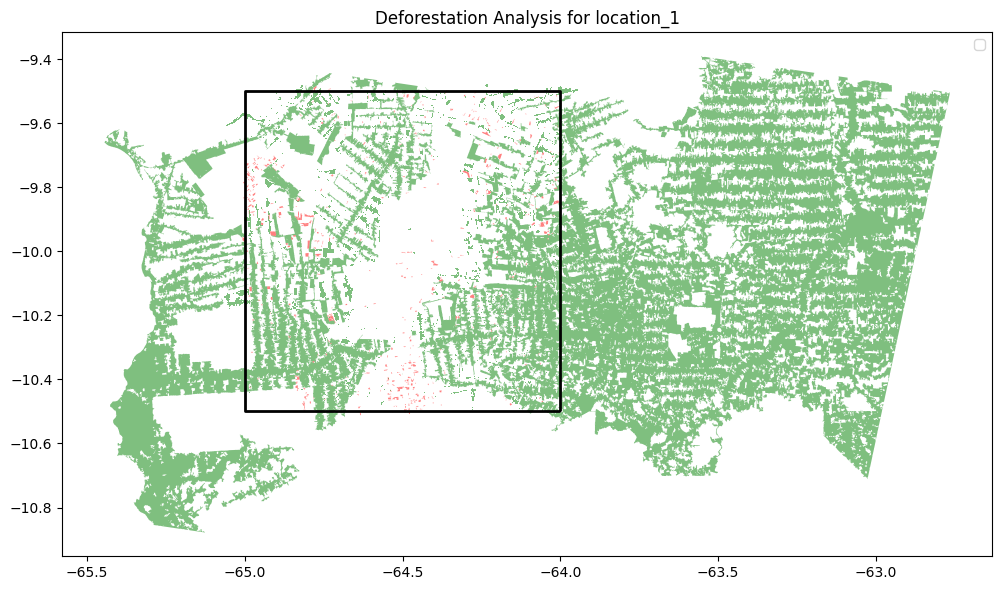

Recent deforestation polygons: 788
Accumulated deforestation polygons: 1057

Processing location_2...


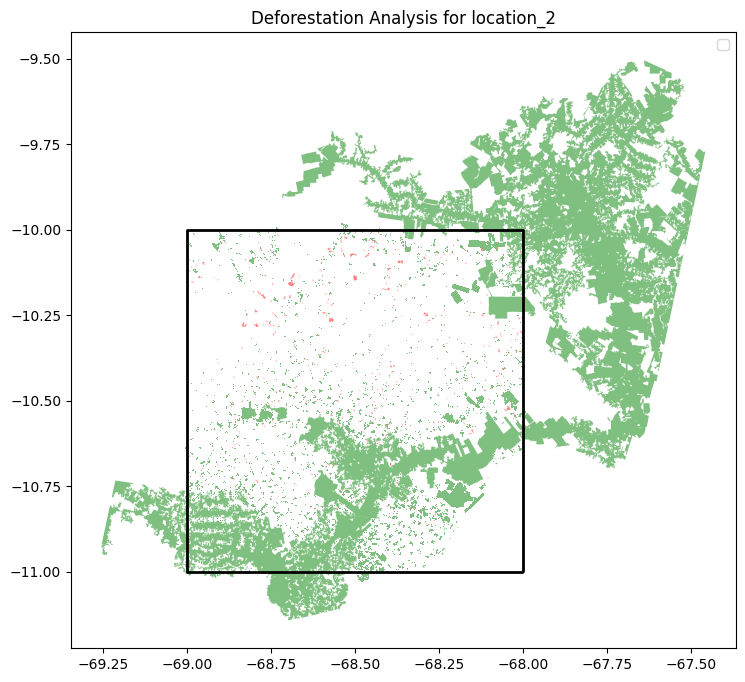

Recent deforestation polygons: 782
Accumulated deforestation polygons: 3837

Processing location_3...


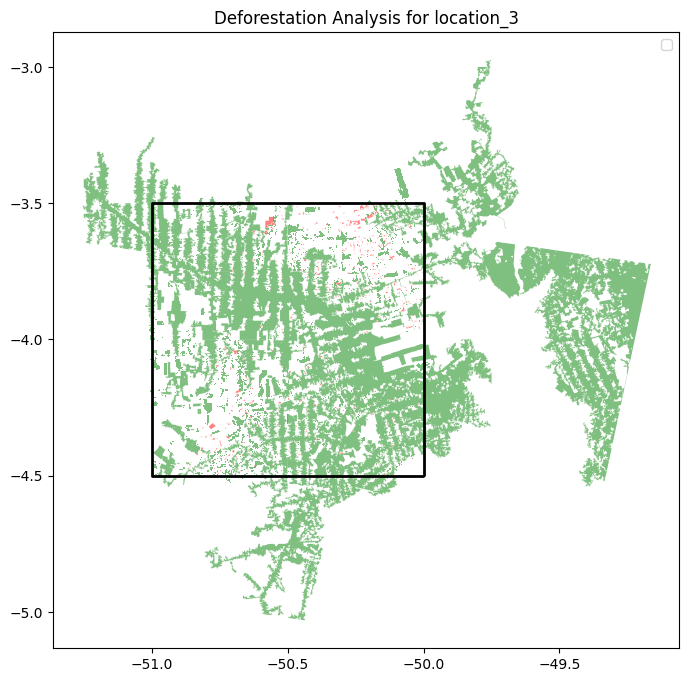

Recent deforestation polygons: 931
Accumulated deforestation polygons: 1223


Map(center=[-8.222292798409725, -61.0798879492343], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
import ee
import geemap
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

# Initialize Earth Engine (if not already initialized)


# Define AOIs
aois = {
    'aoi1': {
        'coords': [-65, -10.5, -64, -9.5],  # [west, south, east, north]
        'name': 'location_1'
    },
    'aoi2': {
        'coords': [-69.0, -11.0, -68.0, -10.0],
        'name': 'location_2'
    },
    'aoi3': {
        'coords': [-51.0, -4.5, -50.0, -3.5],
        'name': 'location_3'
    }
}

# Load the shapefiles
deforestation_shapefile = '/content/drive/MyDrive/honors_thesis/data/raw/prodes/yearly_deforestation_biome.shp'
accumulated_shapefile = '/content/drive/MyDrive/honors_thesis/data/raw/prodes/accumulated_deforestation_2007/accumulated_deforestation_2007.shp'

# Read and filter the recent deforestation data
gdf_def = gpd.read_file(deforestation_shapefile)
gdf_def['image_date'] = pd.to_datetime(gdf_def['image_date'])
mask_def = (gdf_def['image_date'].dt.year == 2023) & (gdf_def['image_date'].dt.month == 7)
filtered_gdf_def = gdf_def[mask_def]

# Read the accumulated deforestation data
gdf_acc = gpd.read_file(accumulated_shapefile)

# Ensure they have the same CRS
if filtered_gdf_def.crs != gdf_acc.crs:
    gdf_acc = gdf_acc.to_crs(filtered_gdf_def.crs)

# Define a function to create visualization for each AOI
def visualize_aoi_with_deforestation(aoi_key, aoi_info):
    """Create a visualization for one AOI with both deforestation datasets"""
    west, south, east, north = aoi_info['coords']
    aoi_name = aoi_info['name']

    # Create the AOI polygon
    from shapely.geometry import box
    aoi_polygon = box(west, south, east, north)
    aoi_gdf = gpd.GeoDataFrame({'geometry': [aoi_polygon]}, crs=filtered_gdf_def.crs)

    # Clip the deforestation data to the AOI
    def_clip = filtered_gdf_def[filtered_gdf_def.intersects(aoi_polygon)]
    acc_clip = gdf_acc[gdf_acc.intersects(aoi_polygon)]

    # Create visualization for this AOI
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the AOI boundary
    aoi_gdf.boundary.plot(ax=ax, color='black', linewidth=2)

    # Plot accumulated deforestation (up to 2007)
    if not acc_clip.empty:
        acc_clip.plot(ax=ax, color='green', alpha=0.5, label='Accumulated deforestation (up to 2007)')

    # Plot recent deforestation (2022-2023)
    if not def_clip.empty:
        def_clip.plot(ax=ax, color='red', alpha=0.5, label='Recent deforestation (2022-2023)')

    # Add title and legend
    ax.set_title(f"Deforestation Analysis for {aoi_name}")
    ax.legend()

    # Save the figure
    plt.savefig(f"deforestation_comparison_{aoi_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

    return def_clip, acc_clip

# Visualize each AOI separately
for key, aoi_info in aois.items():
    print(f"\nProcessing {aoi_info['name']}...")
    def_clip, acc_clip = visualize_aoi_with_deforestation(key, aoi_info)
    print(f"Recent deforestation polygons: {len(def_clip)}")
    print(f"Accumulated deforestation polygons: {len(acc_clip)}")

# Now create an Earth Engine visualization combining all AOIs
def create_ee_map_with_deforestation():
    """Create a Google Earth Engine map with all AOIs and deforestation data"""
    # Create a map
    m = geemap.Map()

    # Add each AOI to the map
    features = []
    for key, aoi in aois.items():
        coords = aoi['coords']
        name = aoi['name']

        # Create the rectangle geometry for each AOI
        geom = ee.Geometry.Rectangle(coords, 'EPSG:4674', False)

        # Create an EE Feature for styling
        feature = ee.Feature(geom, {'name': name})
        features.append(feature)

        # Add the feature layer to the map with boundary only
        m.addLayer(feature, {'color': 'black', 'fillColor': '00000000'}, name)

    # Create a FeatureCollection from all AOIs
    aoi_fc = ee.FeatureCollection(features)

    # Add deforestation datasets if available as Earth Engine assets
    # Note: This assumes you've uploaded the shapefiles to Earth Engine
    # If you haven't, you'll need to do that first through the Earth Engine Code Editor
    try:
        # Replace these with your actual asset IDs
        recent_def_asset = 'projects/ee-anshulsg13/assets/prodes'
        accumulated_def_asset = 'projects/ee-anshulsg13/assets/prodes_before_2008'

        recent_def = ee.FeatureCollection(recent_def_asset)
        accumulated_def = ee.FeatureCollection(accumulated_def_asset)

        # Filter recent deforestation to match the filtering done in GeoPandas
        recent_def = recent_def.filter(ee.Filter.And(
            ee.Filter.eq('year', 2023),
            ee.Filter.eq('month', 7)
        ))

        # Add to map
        m.addLayer(accumulated_def, {'color': 'blue'}, 'Accumulated Deforestation (2007)')
        m.addLayer(recent_def, {'color': 'red'}, 'Recent Deforestation (2022-2023)')
    except Exception as e:
        print(f"Could not add deforestation data from Earth Engine: {e}")
        print("Continuing with AOIs only...")

    # Add a Sentinel-2 background
    sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterDate('2022-07-01', '2022-07-31') \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .median()

    vis_params = {
        'bands': ['B4', 'B3', 'B2'],
        'min': 0,
        'max': 3000
    }

    m.addLayer(sentinel, vis_params, 'Sentinel-2 Background', False)

    # Center the map on all AOIs
    m.centerObject(aoi_fc, zoom=5)

    return m

# Create and display the Earth Engine map
ee_map = create_ee_map_with_deforestation()
ee_map

Analyzing year distribution for recent deforestation using 'year' field...
Raw distinct years found: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Processed years: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Polygon counts by year: {2008: 61183, 2009: 35594, 2010: 40025, 2011: 35868, 2012: 24173, 2013: 31150, 2014: 30458, 2015: 56804, 2016: 53376, 2017: 40057, 2018: 38260, 2019: 60527, 2020: 45672, 2021: 47192, 2022: 65918, 2023: 52452}
Analyzing year distribution for accumulated deforestation using 'year' field...
Raw distinct years found: [2007, 2013, 2008, 2009, 2010, 2011, 2016, 2018, 2019]
Processed years: [2007, 2013, 2008, 2009, 2010, 2011, 2016, 2018, 2019]
Polygon counts by year: {2007: 206389, 2013: 3, 2008: 2, 2009: 5, 2010: 3, 2011: 3, 2016: 2, 2018: 1, 2019: 1}


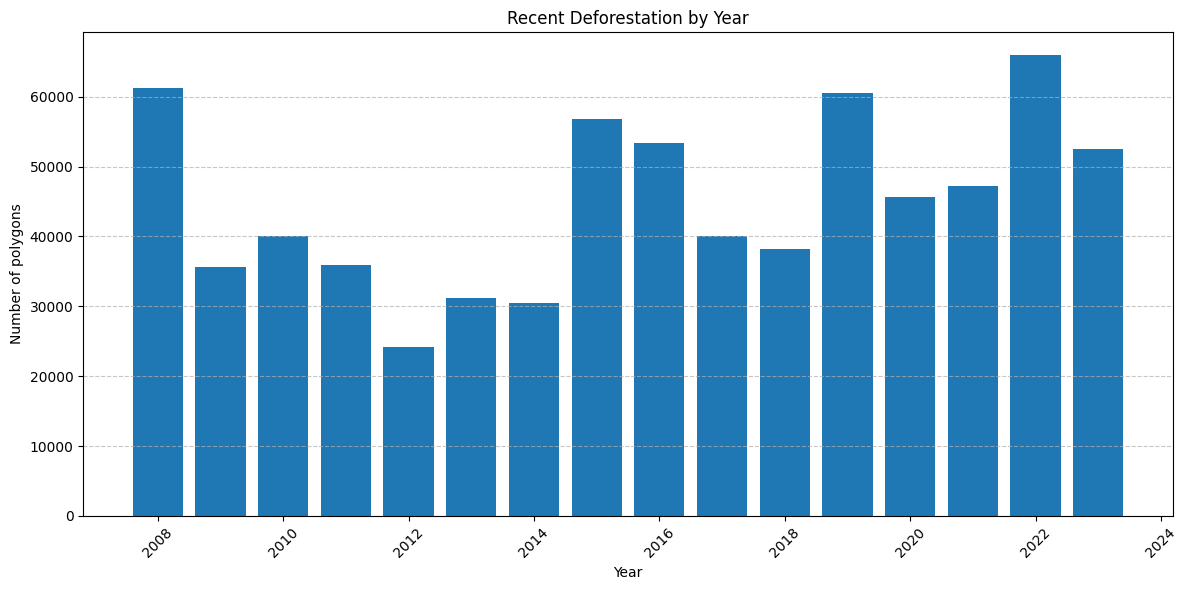

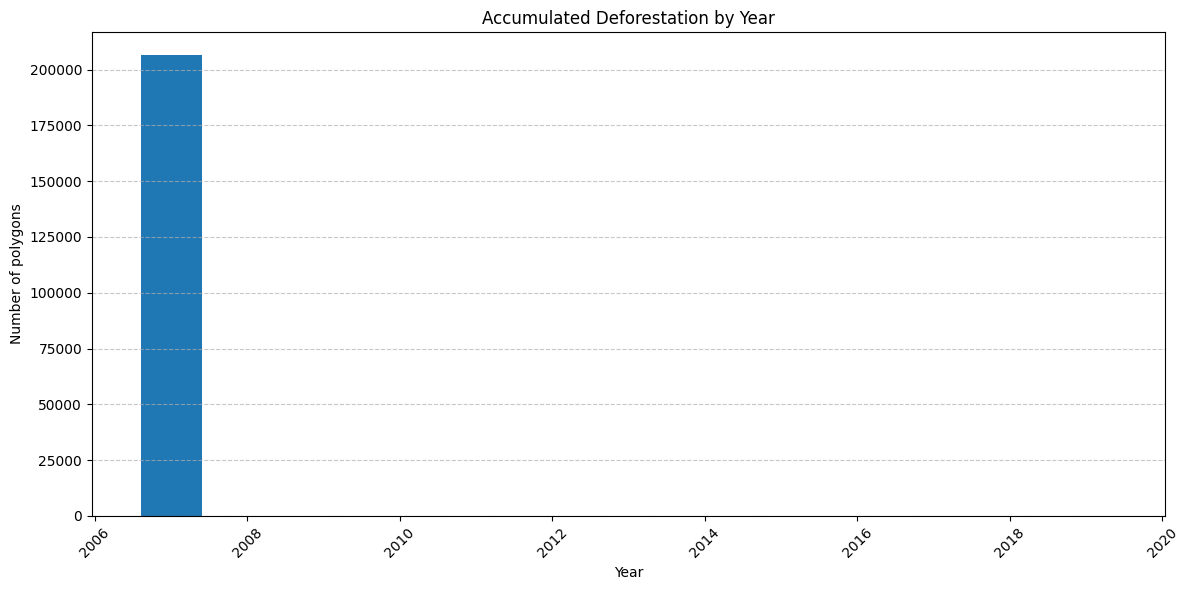


Summary Statistics:
Total polygons in recent deforestation: 718709
Year range: 2008 - 2023
Total polygons in accumulated deforestation: 206409
Year range: 2007 - 2019


In [3]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Initialize Earth Engine


# Define your asset paths
recent_def_asset = 'projects/ee-anshulsg13/assets/prodes'
accumulated_def_asset = 'projects/ee-anshulsg13/assets/prodes_before_2008'

# Load the feature collections
recent_def = ee.FeatureCollection(recent_def_asset)
accumulated_def = ee.FeatureCollection(accumulated_def_asset)

# Function to convert timestamp to year if needed
def process_year_value(value):
    """Convert timestamp to year if the value is a large number (timestamp)"""
    if isinstance(value, (int, float)) and value > 10000:  # Likely a timestamp
        try:
            # Convert milliseconds since epoch to year
            year = datetime.datetime.fromtimestamp(value/1000).year
            return year
        except:
            return value
    return value

# Function to get year distribution using only the 'year' field
def analyze_year_distribution(fc, name):
    print(f"Analyzing year distribution for {name} using 'year' field...")

    try:
        # Get the distinct years
        distinct_years = fc.distinct('year').aggregate_array('year').getInfo()
        print(f"Raw distinct years found: {distinct_years}")

        # Process timestamps if present
        processed_years = [process_year_value(year) for year in distinct_years]
        print(f"Processed years: {processed_years}")

        # Count polygons per year
        year_counts = {}
        for i, year in enumerate(distinct_years):
            count = fc.filter(ee.Filter.eq('year', year)).size().getInfo()
            # Use the processed year for the dictionary key
            year_counts[processed_years[i]] = count

        print(f"Polygon counts by year: {year_counts}")
        return year_counts
    except Exception as e:
        print(f"Error analyzing {name}: {e}")

        # Try to see if the collection has any features
        size = fc.size().getInfo()
        print(f"Collection size: {size}")

        if size > 0:
            # Check available properties
            first_feature = ee.Feature(fc.first())
            properties = first_feature.propertyNames().getInfo()
            print(f"Available properties: {properties}")

            # Check if 'year' exists in a different case
            year_field = None
            for prop in properties:
                if prop.lower() == 'year':
                    year_field = prop
                    print(f"Found year field with different case: {year_field}")
                    break

            if year_field:
                # Try with the correct case
                distinct_years = fc.distinct(year_field).aggregate_array(year_field).getInfo()
                processed_years = [process_year_value(year) for year in distinct_years]

                year_counts = {}
                for i, year in enumerate(distinct_years):
                    count = fc.filter(ee.Filter.eq(year_field, year)).size().getInfo()
                    year_counts[processed_years[i]] = count

                print(f"Polygon counts by year: {year_counts}")
                return year_counts

        return None

# Analyze both datasets
recent_year_counts = analyze_year_distribution(recent_def, "recent deforestation")
acc_year_counts = analyze_year_distribution(accumulated_def, "accumulated deforestation")

# Visualize the results if year counts are available
def plot_year_distribution(year_counts, title):
    if year_counts:
        # Sort by year
        sorted_years = sorted(year_counts.keys())
        counts = [year_counts[year] for year in sorted_years]

        plt.figure(figsize=(12, 6))
        plt.bar(sorted_years, counts)
        plt.title(title)
        plt.xlabel('Year')
        plt.ylabel('Number of polygons')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# Plot the distributions
if recent_year_counts:
    plot_year_distribution(recent_year_counts, "Recent Deforestation by Year")

if acc_year_counts:
    plot_year_distribution(acc_year_counts, "Accumulated Deforestation by Year")

# Summary statistics
print("\nSummary Statistics:")
if recent_year_counts:
    total_recent = sum(recent_year_counts.values())
    print(f"Total polygons in recent deforestation: {total_recent}")
    print(f"Year range: {min(recent_year_counts.keys())} - {max(recent_year_counts.keys())}")

if acc_year_counts:
    total_acc = sum(acc_year_counts.values())
    print(f"Total polygons in accumulated deforestation: {total_acc}")
    print(f"Year range: {min(acc_year_counts.keys())} - {max(acc_year_counts.keys())}")

In [9]:
# Define your asset paths
recent_def_asset = 'projects/ee-anshulsg13/assets/prodes'
accumulated_def_asset = 'projects/ee-anshulsg13/assets/prodes_before_2008'

# Load the feature collections
recent_def = ee.FeatureCollection(recent_def_asset)
accumulated_def = ee.FeatureCollection(accumulated_def_asset)

def get_min_area_km(fc, name):
    # Use Earth Engine’s aggregate_min reducer
    min_val = fc.aggregate_min('area_km').getInfo()
    print(f"Minimum area_km in {name}: {min_val} km²")
    return min_val
def get_max_area_km(fc, name=None):
    max_val = fc.aggregate_max('area_km').getInfo()
    if name:
        print(f"Maximum area_km in {name}: {max_val} km²")
    return max_val

# Example usage:
min_recent = get_min_area_km(recent_def, "recent_def")
min_accum  = get_min_area_km(accumulated_def, "accumulated_def")
min_recent = get_max_area_km(recent_def, "recent_def")
min_accum  = get_max_area_km(accumulated_def, "accumulated_def")


Minimum area_km in recent_def: 0 km²
Minimum area_km in accumulated_def: 3.960044e-09 km²
Maximum area_km in recent_def: 123.47578323421723 km²
Maximum area_km in accumulated_def: 17013.481771099472 km²


In [12]:
def count_areas_by_threshold(fc, threshold=6.25, name=None):
    """
    Counts and returns the number of features in the given FeatureCollection
    with 'area_km' values greater than and less than the specified threshold.

    Args:
        fc (ee.FeatureCollection): The feature collection to analyze
        threshold (float, optional): The area threshold in km². Default is 6.25 km²
        name (str, optional): Name identifier for logging

    Returns:
        tuple: (count_greater, count_less) - Counts of features with area_km greater than
               and less than the specified threshold
    """
    # Get the total count of features
    total_count = fc.size().getInfo()

    # Filter features greater than threshold
    greater_than = fc.filter(ee.Filter.gt('area_km', threshold))
    greater_count = greater_than.size().getInfo()

    # Calculate features less than threshold
    less_count = total_count - greater_count

    # Print results if name is provided
    if name:
        print(f"{name} analysis with {threshold} km² threshold:")
        print(f"  - Features with area > {threshold} km²: {greater_count}")
        print(f"  - Features with area ≤ {threshold} km²: {less_count}")
        print(f"  - Total features: {total_count}")

    return (greater_count, less_count)

greater_recent, less_recent = count_areas_by_threshold(recent_def, 6.25, "Recent deforestation")
greater_accum, less_accum = count_areas_by_threshold(accumulated_def, 6.25, "Accumulated deforestation")

Recent deforestation analysis with 6.25 km² threshold:
  - Features with area > 6.25 km²: 873
  - Features with area ≤ 6.25 km²: 717836
  - Total features: 718709
Accumulated deforestation analysis with 6.25 km² threshold:
  - Features with area > 6.25 km²: 4742
  - Features with area ≤ 6.25 km²: 201667
  - Total features: 206409


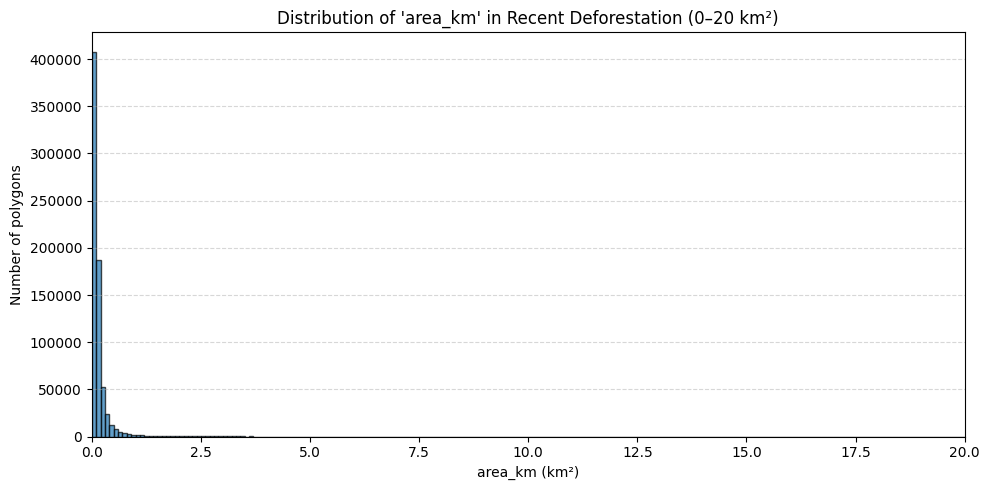

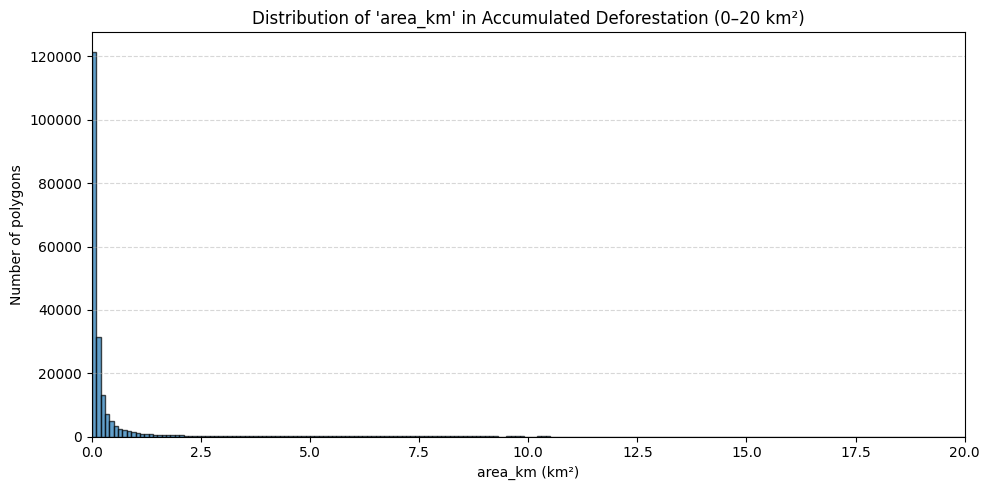

In [6]:
import ee
import numpy as np
import matplotlib.pyplot as plt

# Define your asset paths
recent_def_asset      = 'projects/ee-anshulsg13/assets/prodes'
accumulated_def_asset = 'projects/ee-anshulsg13/assets/prodes_before_2008'

# Load the feature collections
recent_def      = ee.FeatureCollection(recent_def_asset)
accumulated_def = ee.FeatureCollection(accumulated_def_asset)

def plot_area_distribution(fc, name, max_range=20, bin_width=0.1):
    """
    Fetches all 'area_km' values and plots a histogram from 0 to max_range km²,
    using bins of width bin_width.
    """
    # 1) pull down the list of area_km values
    areas = fc.aggregate_array('area_km').getInfo()

    # 2) build fine-grained bins
    bins = np.arange(0, max_range + bin_width, bin_width)

    # 3) plot
    plt.figure(figsize=(10, 5))
    plt.hist(areas, bins=bins, edgecolor='black', alpha=0.7)
    plt.xlim(0, max_range)
    plt.title(f"Distribution of 'area_km' in {name} (0–{max_range} km²)")
    plt.xlabel("area_km (km²)")
    plt.ylabel("Number of polygons")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Plot for both collections with 0.1 km² bins
plot_area_distribution(recent_def,      "Recent Deforestation",      max_range=20, bin_width=0.1)
plot_area_distribution(accumulated_def, "Accumulated Deforestation", max_range=20, bin_width=0.1)


In [ ]:
import ee
import geemap

# Define AOIs
aois = {
    'aoi1': {
        'coords': [-65, -10.5, -64, -9.5],  # [west, south, east, north]
        'name': 'location_1'
    },
    'aoi2': {
        'coords': [-69.0, -11.0, -68.0, -10.0],
        'name': 'location_2'
    },
    'aoi3': {
        'coords': [-51.0, -4.5, -50.0, -3.5],
        'name': 'location_3'
    }
}

# Create a map
m = geemap.Map()

# Add each AOI to the map
features = []
for key, aoi in aois.items():
    coords = aoi['coords']
    name = aoi['name']

    # Create the rectangle geometry for each AOI
    geom = ee.Geometry.Rectangle(coords, 'EPSG:4674', False)

    # Create an EE Feature for styling
    feature = ee.Feature(geom, {'name': name})
    features.append(feature)

    # Add the feature layer to the map with boundary only
    m.addLayer(feature, {'color': 'black', 'fillColor': '00000000'}, name)

# Create a FeatureCollection from all AOIs
aoi_fc = ee.FeatureCollection(features)

# Define asset paths
recent_def_asset = 'projects/ee-anshulsg13/assets/prodes'
accumulated_def_asset = 'projects/ee-anshulsg13/assets/prodes_before_2008'

# Load the feature collections
recent_def = ee.FeatureCollection(recent_def_asset)
accumulated_def = ee.FeatureCollection(accumulated_def_asset)

# Filter by image_date for July 2023
# Create date range for July 2023
start_date = ee.Date.fromYMD(2023, 7, 1).millis()
end_date = ee.Date.fromYMD(2023, 8, 1).millis()

# Filter recent deforestation to July 2023
recent_def_filtered = recent_def.filter(
    ee.Filter.And(
        ee.Filter.gte('image_date', start_date),
        ee.Filter.lt('image_date', end_date)
    )
)

# Add layers to map
#m.addLayer(accumulated_def, {'color': 'blue'}, 'Accumulated Deforestation (up to 2007)')
m.addLayer(recent_def_filtered, {'color': 'red'}, 'Recent Deforestation (July 2023)')

# Add a Sentinel-2 background
sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate('2022-07-01', '2022-07-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .median()

vis_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000
}

m.addLayer(sentinel, vis_params, 'Sentinel-2 Background', False)

# Center the map on all AOIs
m.centerObject(aoi_fc, zoom=5)

# Display the map
m

Map(center=[-8.222292798409725, -61.0798879492343], controls=(WidgetControl(options=['position', 'transparent_…

Monthly distribution of deforestation events in 2023:
month
7     17900
8     37233
9     10177
10      608
Name: count, dtype: int64


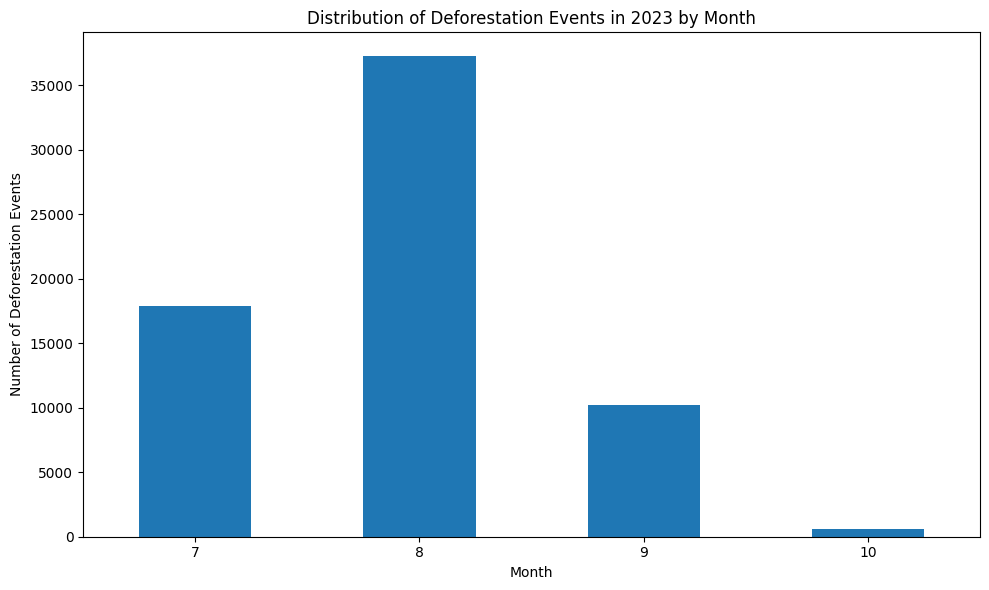

In [ ]:
accumulated_shapefile = '/content/drive/MyDrive/honors_thesis/data/raw/prodes/accumulated_deforestation_2007/accumulated_deforestation_2007.shp'
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to your deforestation shapefile
deforestation_shapefile = '/content/drive/MyDrive/honors_thesis/data/raw/prodes/yearly_deforestation_biome.shp'

# Read the shapefile
gdf_def = gpd.read_file(deforestation_shapefile)

# Convert the 'image_date' column to datetime
gdf_def['image_date'] = pd.to_datetime(gdf_def['image_date'])

# Filter for events in 2023
gdf_2023 = gdf_def[gdf_def['image_date'].dt.year == 2022
                   ]

# Create a new column for the month extracted from 'image_date'
gdf_2023['month'] = gdf_2023['image_date'].dt.month

# Group by month and count the number of deforestation events per month
monthly_counts = gdf_2023['month'].value_counts().sort_index()

# Print the monthly distribution
print("Monthly distribution of deforestation events in 2023:")
print(monthly_counts)

# Plot the distribution as a bar chart
monthly_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Month')
plt.ylabel('Number of Deforestation Events')
plt.title('Distribution of Deforestation Events in 2023 by Month')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import ee
import geemap
import time # Not strictly needed for visualization, but often useful

# Trigger the authentication flow (if needed)
try:
    # Attempt to initialize without prompting first
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com') # Use high volume endpoint
    print("EE Initialized successfully (likely using existing credentials).")
except Exception as e:
    print(f"Initial Initialize failed ({e}), attempting Authentication...")
    try:
        ee.Authenticate()
        # Initialize with specific project and high volume endpoint after auth
        ee.Initialize(project='ee-anshulsg13', opt_url='https://earthengine-highvolume.googleapis.com')
        print("EE Authentication successful and Initialized.")
    except Exception as auth_e:
        print(f"EE Authentication or Initialization failed: {auth_e}")
        print("Please ensure you have authenticated correctly and the project ID is valid.")
        exit()


# --- Define AOIs (only needed for centering the map now) ---
aois = {
    # 'aoi1': { ... }, # Not needed for this visualization unless centering changes
    # 'aoi2': { ... },
    'aoi3': {
        'coords': [-51.0, -4.5, -50.0, -3.5],
        'name': 'location_3'
    }
}

# --- Load Assets ---
recent_def_asset = 'projects/ee-anshulsg13/assets/prodes'
accumulated_def_asset = 'projects/ee-anshulsg13/assets/prodes_before_2008'
prodes_recent = None # Initialize to None
prodes_accumulated = None # Initialize to None

try:
    # Load the FeatureCollections from the asset paths
    prodes_recent = ee.FeatureCollection(recent_def_asset)
    prodes_accumulated = ee.FeatureCollection(accumulated_def_asset)
    # Perform a quick operation to check if assets are accessible
    asset_size_recent = prodes_recent.limit(1).size().getInfo()
    asset_size_accum = prodes_accumulated.limit(1).size().getInfo() # Check both
    print(f"Asset '{recent_def_asset}' loaded successfully.")
    print(f"Asset '{accumulated_def_asset}' loaded successfully.")
except ee.EEException as e:
    print(f"Error loading assets: {e}")
    print("Please ensure the asset paths are correct and you have read access.")
    # Exit if asset loading fails
    exit()
except Exception as e:
    print(f"An unexpected error occurred during asset loading: {e}")
    exit()

# --- Define Target Year ---
TARGET_YEAR = 2023 # Year for class 1 deforestation (recent change)

# --- Prepare Deforestation Data ---
print(f"\nFiltering deforestation for target year: {TARGET_YEAR}")
# Class 1: Target year deforestation
# Ensure the asset has a 'year' property for this filter to work
# Using .eq() which is generally preferred for single value checks
def_target_year = prodes_recent.filter(
    ee.Filter.eq('year', TARGET_YEAR)
)

print(f"Filtering deforestation for past years (<= {TARGET_YEAR - 1}) and combining accumulated")
# Class 2: Deforestation before the target year
# Using .lt() which is generally safer than calendarRange for 'less than' a year
def_before_target = prodes_recent.filter(
    ee.Filter.lt('year', TARGET_YEAR)
)
# Merge the recent pre-target data with the older accumulated data
def_past = def_before_target.merge(prodes_accumulated)

# --- Visualization for Debugging ---

# Get the specific AOI info for centering
aoi_key_to_center = 'aoi3'
if aoi_key_to_center not in aois:
    print(f"Error: AOI key '{aoi_key_to_center}' not found in aois dictionary for centering.")
    aoi_center_geom = None
else:
    aoi_info = aois[aoi_key_to_center]
    aoi_name = aoi_info['name']
    coords = aoi_info['coords']
    print(f"\n--- Visualizing All Deforestation Features (Centering on AOI: {aoi_name}) ---")
    # Create AOI geometry just for centering and boundary display
    aoi_center_geom = ee.Geometry.Rectangle(coords, 'EPSG:4326', False)


# Create map centered on the AOI
m = geemap.Map()
if aoi_center_geom:
    m.centerObject(aoi_center_geom, 9) # Adjust zoom level if needed
else:
    m.setCenter(0, 0, 2) # Default global center

# Add AOI boundary outline (optional, shows where you centered)
if aoi_center_geom:
    aoi_boundary_style = {'color': '000000', 'fillColor': '00000000'} # Black outline
    m.addLayer(aoi_center_geom, aoi_boundary_style, f'{aoi_name} Boundary (Center)')

# --- Add Deforestation Layers ---
# Add Past Deforestation first (so target year draws on top)
past_def_style = {'color': '00FFFF'} # Cyan
m.addLayer(def_past, past_def_style, f'Past Deforestation (< {TARGET_YEAR})')

# Add Target Year Deforestation second
target_year_style = {'color': 'FFFF00'} # Bright Yellow
m.addLayer(def_target_year, target_year_style, f'Target Year Features ({TARGET_YEAR})')


# Add a satellite basemap too if needed
m.add_basemap('SATELLITE')

# --- Print Total Feature Counts ---
try:
    count_target = def_target_year.size().getInfo()
    count_past = def_past.size().getInfo() # Count combined past features
    print(f"\nTotal count of target year ({TARGET_YEAR}) features: {count_target}")
    print(f"Total count of past (< {TARGET_YEAR}) features (combined): {count_past}")
    if count_target == 0:
         print(f"Warning: The asset contains 0 features for the target year {TARGET_YEAR}.")
    if count_past == 0:
         print(f"Warning: The assets contain 0 features for past deforestation (< {TARGET_YEAR}).")
except Exception as e:
    print(f"Could not get total feature counts: {e}")


# Display the map in Colab/Jupyter
try:
    display(m)
    print("\nMap displayed above.")
    print(f"Past deforestation (<{TARGET_YEAR}) shown in CYAN.")
    print(f"Target year ({TARGET_YEAR}) features shown in YELLOW.")
    if aoi_center_geom:
        print(f"Map centered near the black AOI box for {aoi_name}.")
except NameError:
    print("\nMap display skipped ('display' function not available or geemap not fully functional).")
    print("Check the GEE Code Editor link if generated, or run in a notebook environment.")

Initial Initialize failed (ee.Initialize: no project found. Call with project= or see http://goo.gle/ee-auth.), attempting Authentication...
EE Authentication successful and Initialized.
Asset 'projects/ee-anshulsg13/assets/prodes' loaded successfully.
Asset 'projects/ee-anshulsg13/assets/prodes_before_2008' loaded successfully.

Filtering deforestation for target year: 2023
Filtering deforestation for past years (<= 2022) and combining accumulated

--- Visualizing All Deforestation Features (Centering on AOI: location_3) ---

Total count of target year (2023) features: 52452
Total count of past (< 2023) features (combined): 872666


Map(center=[-3.9999489000211303, -50.49999999999977], controls=(WidgetControl(options=['position', 'transparen…


Map displayed above.
Past deforestation (<2023) shown in CYAN.
Target year (2023) features shown in YELLOW.
Map centered near the black AOI box for location_3.


Deforestation features per year:
    Year  Count
0   2008  61183
1   2009  35594
2   2010  40025
3   2011  35868
4   2012  24173
5   2013  31150
6   2014  30458
7   2015  56804
8   2016  53376
9   2017  40057
10  2018  38260
11  2019  60527
12  2020  45672
13  2021  47192
14  2022  65918
15  2023  52452


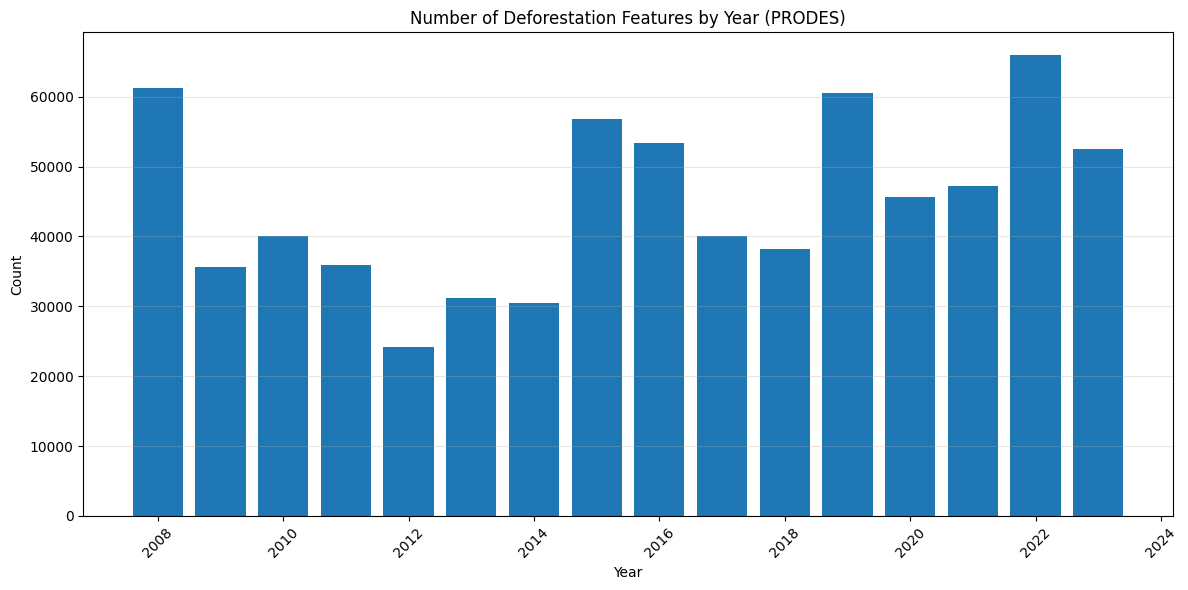


Total number of features in the recent deforestation dataset: 718709

Percentage of deforestation by year:
    Year  Count  Percentage
0   2008  61183    8.512903
1   2009  35594    4.952491
2   2010  40025    5.569013
3   2011  35868    4.990615
4   2012  24173    3.363392
5   2013  31150    4.334160
6   2014  30458    4.237877
7   2015  56804    7.903616
8   2016  53376    7.426650
9   2017  40057    5.573466
10  2018  38260    5.323434
11  2019  60527    8.421628
12  2020  45672    6.354728
13  2021  47192    6.566218
14  2022  65918    9.171723
15  2023  52452    7.298086


In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Initialize Earth Engine


# Define your asset paths
recent_def_asset = 'projects/ee-anshulsg13/assets/prodes'
accumulated_def_asset = 'projects/ee-anshulsg13/assets/prodes_before_2008'

# Load the feature collections
recent_def = ee.FeatureCollection(recent_def_asset)
accumulated_def = ee.FeatureCollection(accumulated_def_asset)

def get_year_counts():
    # Get all unique years from the collection
    distinct_years = recent_def.aggregate_array('year').distinct().sort()

    # Convert to Python list
    years_list = distinct_years.getInfo()

    # Initialize dictionary to store counts
    year_counts = {}

    # For each year, count the number of features
    for year in years_list:
        # Filter the collection to just features with this year
        year_features = recent_def.filter(ee.Filter.eq('year', year))

        # Get the count
        count = year_features.size().getInfo()

        # Store in dictionary
        year_counts[year] = count

    return year_counts

# Get the counts
year_counts = get_year_counts()

# Convert to pandas DataFrame for easier manipulation and visualization
df = pd.DataFrame(list(year_counts.items()), columns=['Year', 'Count'])
print("Deforestation features per year:")
print(df)

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(df['Year'], df['Count'])
plt.title('Number of Deforestation Features by Year (PRODES)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.savefig('prodes_year_count.png')
plt.show()

# Get total number of features
total_features = recent_def.size().getInfo()
print(f"\nTotal number of features in the recent deforestation dataset: {total_features}")

# Additional analysis: Calculate the percentage of deforestation by year
df['Percentage'] = (df['Count'] / df['Count'].sum()) * 100
print("\nPercentage of deforestation by year:")
print(df[['Year', 'Count', 'Percentage']])



Viewing .tif and npy file

In [ ]:
!pip install rasterio
import rasterio
import os
from pathlib import Path

# Define the folder path
folder_path = "/content/drive/MyDrive/honors_thesis/data/raw/location_1/sentinel2/july2022"

# Iterate through all .tif files in the folder
for file in Path(folder_path).glob('*.tif'):
    print(f"\nAnalyzing: {file.name}")
    try:
        with rasterio.open(file) as src:
            print("CRS:", src.crs)
            print
            ("\nBounds:")
            print(f"Left: {src.bounds.left:.2f}")
            print(f"Bottom: {src.bounds.bottom:.2f}")
            print(f"Right: {src.bounds.right:.2f}")
            print(f"Top: {src.bounds.top:.2f}")
            print(f"Resolution: {src.res}")
            print(f"Size: {src.width}x{src.height} pixels")
            print(f"Number of bands: {src.count}")
            print("-" * 50)
    except Exception as e:
        print(f"Error reading {file.name}: {e}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 80.9 MB/s eta 0:00:00

Analyzing: sentinel2_mosaic (1).tif
CRS: EPSG:4674
Left: -65.00
Bottom: -10.50
Right: -64.00
Top: -9.50
Resolution: (8.983152841195215e-05, 8.983152841195215e-05)
Size: 11133x11133 pixels
Number of bands: 4
--------------------------------------------------

Analyzing: sentinel2_mosaic.tif
CRS: EPSG:4674
Left: -65.00
Bottom: -10.50
Right: -64.00
Top: -9.50
Resolution: (8.983152841195215e-05, 8.983152841195215e-05)
Size: 11133x11133 pixels
Number of bands: 4
--------------------------------------------------


In [ ]:
#Tif File analysis
